In [1]:
# Pfad zur Eingabedatei und zur Ausgabedatei
input_file_path = r"C:\Users\Pfrei\Documents\Docker\Data_new\ALS_DGM_10M_UTM33N.asc"
output_file_path = r"C:\Users\Pfrei\Documents\Docker\Data_new\Data_dots.asc"

# Datei einlesen, ersetzen und speichern
with open(input_file_path, 'r') as input_file:
    # Inhalt der Datei lesen und alle Kommas durch Punkte ersetzen
    file_content = input_file.read().replace(',', '.')

# Modifizierte Inhalte in einer neuen Datei speichern
with open(output_file_path, 'w') as output_file:
    output_file.write(file_content)

print(f"Die Datei wurde erfolgreich gespeichert unter: {output_file_path}")


Die Datei wurde erfolgreich gespeichert unter: C:\Users\Pfrei\Documents\Docker\Data_new\Data_dots.asc


Keine Überflutungsbereiche gefunden.


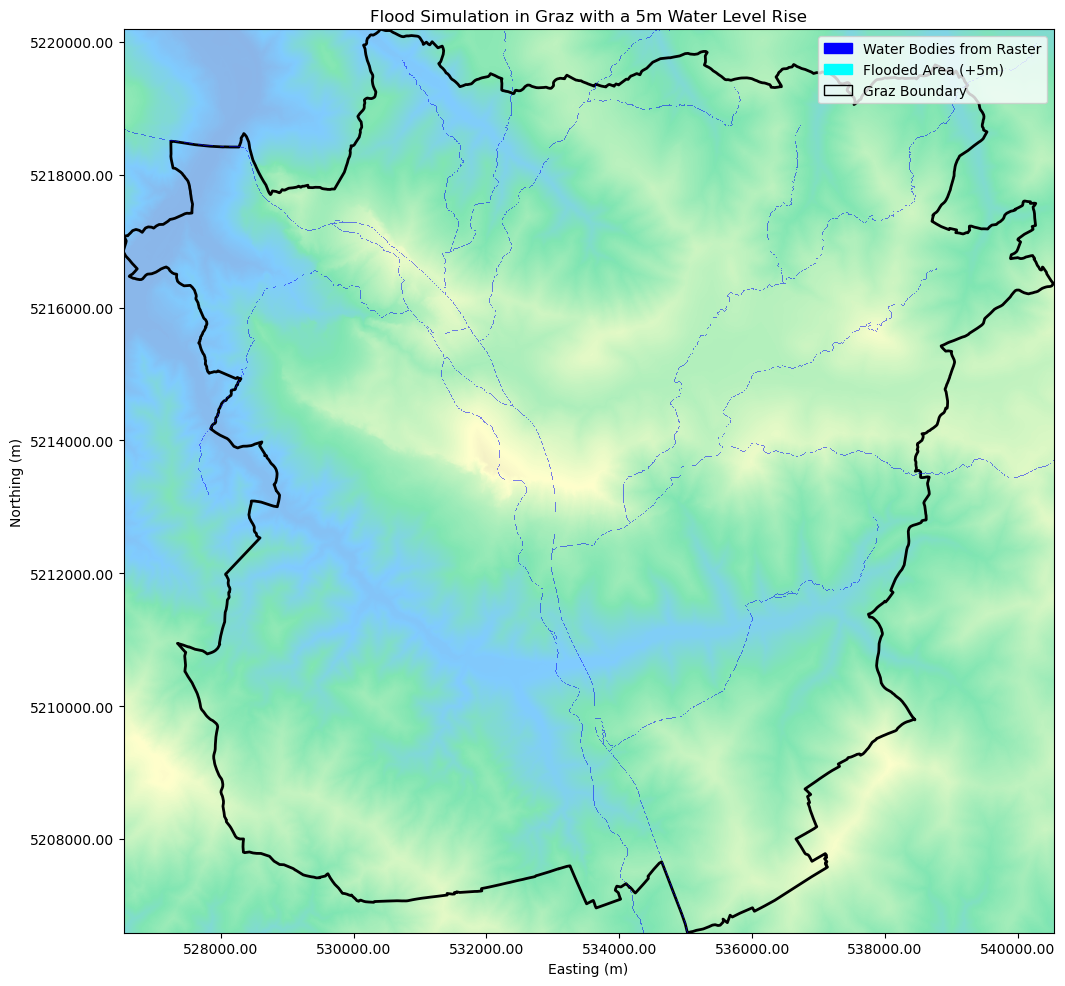

In [41]:
import rasterio
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon
from matplotlib.patches import Patch
import matplotlib.ticker as mticker

# Funktion: Wasseranstieg simulieren
def simulate_flood(dem_data, extent, water_bodies, rise_meters=5):
    """
    Simuliert eine Überflutung, indem die DEM-Daten mit dem Wasserstand verglichen werden.
    """
    x_min, x_max, y_min, y_max = extent

    # Maskiere alle Bereiche, die unter dem neuen Wasserstand liegen
    flooded = dem_data <= rise_meters

    # Erzeuge eine Geodatenstruktur (Gitterpunkte) für die gefluteten Bereiche
    flooded_indices = np.argwhere(flooded)  # Nur geflutete Pixel
    if flooded_indices.size == 0:  # Keine Überflutungen gefunden
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:32633")

    flooded_points = [
        (x_min + j * cellsize, y_max - i * cellsize)  # Koordinaten der gefluteten Pixel
        for i, j in flooded_indices
    ]
    flooded_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            [p[0] for p in flooded_points],
            [p[1] for p in flooded_points]
        ),
        crs="EPSG:32633"
    )
    
    # Finde Überflutungen in der Nähe von Gewässern
    flooded_near_water = gpd.sjoin(flooded_gdf, water_bodies, how="inner", predicate="intersects")
    return flooded_near_water

# Daten abrufen
place_name = "Graz, Austria"
utm_crs = "EPSG:32633"

# Graz-Grenzen abrufen
graz_boundary = ox.geocode_to_gdf(place_name).to_crs(utm_crs)

# DEM laden
dem_path = r"C:\Users\Pfrei\Documents\Docker\Data_new\Data_dots_neu.asc"

# Lade Header-Informationen aus DEM
with open(dem_path, 'r') as f:
    header = [next(f) for _ in range(6)]
    ncols = int(header[0].split()[1])
    nrows = int(header[1].split()[1])
    xllcorner = float(header[2].split()[1])
    yllcorner = float(header[3].split()[1])
    cellsize = float(header[4].split()[1])
    nodata_value = float(header[5].split()[1])

# DEM-Daten laden
dem_data = np.loadtxt(dem_path, skiprows=6)
dem_data[dem_data == nodata_value] = np.nan  # NoData-Werte als NaN

# DEM-Extent berechnen
extent = [
    xllcorner,
    xllcorner + ncols * cellsize,
    yllcorner,
    yllcorner + nrows * cellsize
]

# Graz-Grenzen verwenden, um den Bereich zu beschränken
graz_bounds = graz_boundary.total_bounds  # [minx, miny, maxx, maxy]

# GeoTIFF für Gewässer laden (z. B. ein RASTER)
water_bodies_raster_path = r"C:\Users\Pfrei\Documents\Docker\Data_new\Waterways_raster.tif"

# Öffnen des Wasser-Raster-GeoTIFFs
with rasterio.open(water_bodies_raster_path) as water_ds:
    water_bodies_data = water_ds.read(1)  # Liest das erste Band des GeoTIFFs
    
    # Erstellen einer Maske, wo der Wert des Rasters das Wasser darstellt (z.B. 1 für Gewässer)
    water_bodies_mask = water_bodies_data == 1  # Annahme, dass Gewässer durch den Wert 1 dargestellt werden
    
    # Umwandlung der Raster-Maske in ein Polygon, das als GeoDataFrame verwendet werden kann
    water_bodies_polygons = []
    for (i, j) in np.argwhere(water_bodies_mask):
        # Berechne die Koordinaten für jedes Gewässer-Pixel
        x = water_ds.transform[2] + j * water_ds.transform[0]
        y = water_ds.transform[5] + i * water_ds.transform[4]
        water_bodies_polygons.append(Polygon([(x, y), (x + cellsize, y), (x + cellsize, y + cellsize), (x, y + cellsize)]))

    # Umwandlung der Polygon-Liste in ein GeoDataFrame
    water_bodies_gdf = gpd.GeoDataFrame(geometry=water_bodies_polygons, crs=water_ds.crs)

# Funktion ausführen: Simulation eines Wasseranstiegs
rise_meters = 5 # Hier den Wasseranstieg anpassen
flooded_area = simulate_flood(dem_data, extent, water_bodies_gdf, rise_meters)

# Funktion zum Formatieren der Koordinaten
def format_coords(x, _):
    return f"{x:.2f}"  # Zwei Nachkommastellen

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# DEM als Hintergrund, zugeschnitten auf Graz
plt.imshow(
    dem_data,
    extent=extent,
    cmap="terrain",
    origin="lower",
    alpha=0.5
)
ax.set_xlim(graz_bounds[0], graz_bounds[2])  # x-Achse auf Graz beschränken
ax.set_ylim(graz_bounds[1], graz_bounds[3])  # y-Achse auf Graz beschränken

# Graz-Grenzen
graz_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Graz Boundary")

# Gewässer aus dem GeoTIFF
water_bodies_gdf.plot(ax=ax, color="blue", alpha=0.5, label="Water Bodies from Raster")

# Überflutete Gebiete (nur wenn nicht leer)
if not flooded_area.empty:
    flooded_area.plot(ax=ax, color="cyan", alpha=0.5, markersize=1, label=f"Flooded Area (+{rise_meters}m)")
else:
    print("Keine Überflutungsbereiche gefunden.")

# Benutzerdefinierte Legende
handles = [
    Patch(color="blue", label="Water Bodies from Raster"),
    Patch(color="cyan", label=f"Flooded Area (+{rise_meters}m)"),
    Patch(edgecolor="black", facecolor="none", label="Graz Boundary")
]
ax.legend(handles=handles, loc="upper right")

# Titel und Achsen
plt.title(f"Flood Simulation in Graz with a {rise_meters}m Water Level Rise")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

# Einheitliche Dezimalzahlen auf den Achsen
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coords))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coords))

plt.show()

#plt.savefig("C:\Users\Pfrei\Documents\Docker\Data_new\Flood2m.png)

Keine Überflutungsbereiche gefunden.


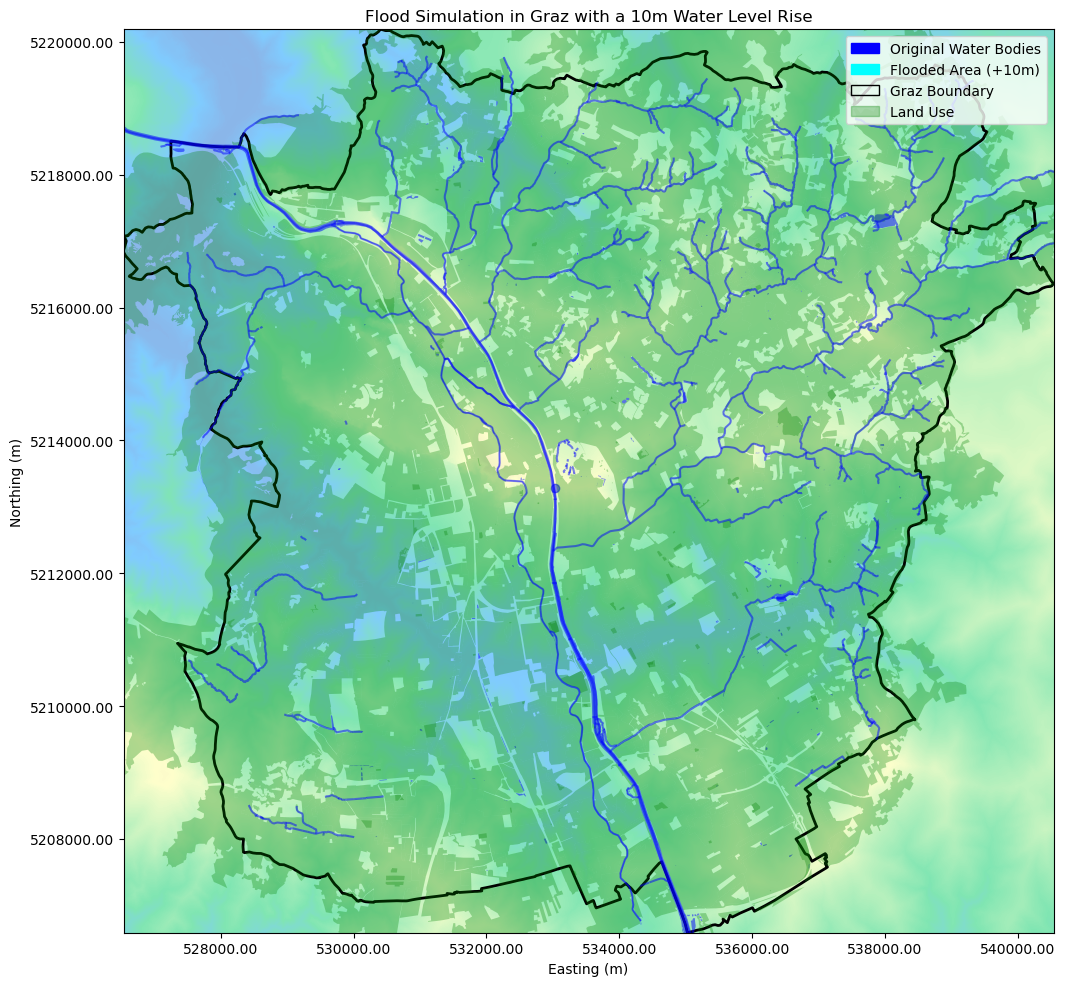

In [34]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.patches import Patch
import matplotlib.ticker as mticker

# Funktion: Wasseranstieg simulieren
def simulate_flood(dem_data, extent, water_bodies, rise_meters=10):
    """
    Simuliert eine Überflutung, indem die DEM-Daten mit dem Wasserstand verglichen werden.
    """
    x_min, x_max, y_min, y_max = extent

    # Maskiere alle Bereiche, die unter dem neuen Wasserstand liegen
    flooded = dem_data <= rise_meters

    # Erzeuge eine Geodatenstruktur (Gitterpunkte) für die gefluteten Bereiche
    flooded_indices = np.argwhere(flooded)  # Nur geflutete Pixel
    if flooded_indices.size == 0:  # Keine Überflutungen gefunden
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:32633")

    flooded_points = [
        (x_min + j * cellsize, y_max - i * cellsize)  # Koordinaten der gefluteten Pixel
        for i, j in flooded_indices
    ]
    flooded_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            [p[0] for p in flooded_points],
            [p[1] for p in flooded_points]
        ),
        crs="EPSG:32633"
    )
    
    # Finde Überflutungen in der Nähe von Gewässern
    flooded_near_water = gpd.sjoin(flooded_gdf, water_bodies, how="inner", predicate="intersects")
    return flooded_near_water

# Datenabruf
place_name = "Graz, Austria"
utm_crs = "EPSG:32633"

# Stadtgrenzen und Gewässer abrufen
graz_boundary = ox.geocode_to_gdf(place_name).to_crs(utm_crs)
water_bodies = ox.features_from_place(
    place_name,
    tags={"waterway": ["river", "stream", "canal", "drain"], "natural": ["water", "wetland"]}
).to_crs(utm_crs)

# Landnutzungsdaten abrufen
land_use = ox.features_from_place(
    place_name,
    tags={"landuse": ["residential", "commercial", "industrial", "retail", "urban", "farmland", "forest"]}
).to_crs(utm_crs)

# DEM laden
dem_path = r"C:\Users\Pfrei\Documents\Docker\Data_new\Data_dots_neu.asc"

# Lade Header-Informationen aus DEM
with open(dem_path, 'r') as f:
    header = [next(f) for _ in range(6)]
    ncols = int(header[0].split()[1])
    nrows = int(header[1].split()[1])
    xllcorner = float(header[2].split()[1])
    yllcorner = float(header[3].split()[1])
    cellsize = float(header[4].split()[1])
    nodata_value = float(header[5].split()[1])

# DEM-Daten laden
dem_data = np.loadtxt(dem_path, skiprows=6)
dem_data[dem_data == nodata_value] = np.nan  # NoData-Werte als NaN

# DEM-Extent berechnen
extent = [
    xllcorner,
    xllcorner + ncols * cellsize,
    yllcorner,
    yllcorner + nrows * cellsize
]

# Graz-Grenzen verwenden, um den Bereich zu beschränken
graz_bounds = graz_boundary.total_bounds  # [minx, miny, maxx, maxy]

# Funktion ausführen: Simulation eines Wasseranstiegs
rise_meters = 10  # Hier den Wasseranstieg anpassen
flooded_area = simulate_flood(dem_data, extent, water_bodies, rise_meters)

# Funktion zum Formatieren der Koordinaten
def format_coords(x, _):
    return f"{x:.2f}"  # Zwei Nachkommastellen

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# DEM als Hintergrund, zugeschnitten auf Graz
plt.imshow(
    dem_data,
    extent=extent,
    cmap="terrain",
    origin="lower",
    alpha=0.5
)
ax.set_xlim(graz_bounds[0], graz_bounds[2])  # x-Achse auf Graz beschränken
ax.set_ylim(graz_bounds[1], graz_bounds[3])  # y-Achse auf Graz beschränken

# Graz-Grenzen
graz_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Graz Boundary")

# Ursprüngliche Gewässer
water_bodies.plot(ax=ax, color="blue", alpha=0.5, label="Original Water Bodies")

# Landnutzung
land_use.plot(ax=ax, color="green", alpha=0.3, label="Land Use")

# Überflutete Gebiete (nur wenn nicht leer)
if not flooded_area.empty:
    flooded_area.plot(ax=ax, color="cyan", alpha=0.5, markersize=1, label=f"Flooded Area (+{rise_meters}m)")
else:
    print("Keine Überflutungsbereiche gefunden.")

# Benutzerdefinierte Legende
handles = [
    Patch(color="blue", label="Original Water Bodies"),
    Patch(color="cyan", label=f"Flooded Area (+{rise_meters}m)"),
    Patch(edgecolor="black", facecolor="none", label="Graz Boundary"),
    Patch(color="green", alpha=0.3, label="Land Use")
]
ax.legend(handles=handles, loc="upper right")

# Titel und Achsen
plt.title(f"Flood Simulation in Graz with a {rise_meters}m Water Level Rise")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

# Einheitliche Dezimalzahlen auf den Achsen
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coords))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coords))

plt.show()
